# Рекомендация тарифов

Оператор мобильной связи «Мегалайн» выяснил: многие клиенты пользуются архивными тарифами. Они хотят построить систему, способную проанализировать поведение клиентов и предложить пользователям новый тариф: «Смарт» или «Ультра».

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением accuracy. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте accuracy на тестовой выборке самостоятельно.

## Откройте и изучите файл

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn import tree
from sklearn.model_selection import GridSearchCV

In [2]:
df = pd.read_csv('/datasets/users_behavior.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [4]:
df.sample(10)

,calls,minutes,messages,mb_used,is_ultra
2001,46.0,335.67,26.0,8376.75,0
1259,81.0,606.20,36.0,20066.10,0
1081,57.0,445.41,1.0,8197.18,0
1683,11.0,81.29,1.0,4000.01,0
2281,34.0,258.97,107.0,10294.77,0
452,26.0,198.05,19.0,11336.44,0
2171,26.0,118.57,146.0,15109.08,1
2293,72.0,411.84,0.0,10435.47,0
786,83.0,705.90,84.0,16082.16,0
2011,83.0,670.68,54.0,19679.78,0


Каждый объект в наборе данных — это информация о поведении одного пользователя за месяц. В датасете 3214 строк и 5 столбцов: 
- сalls — количество звонков,
- minutes — суммарная длительность звонков в минутах,
- messages — количество sms-сообщений,
- mb_used — израсходованный интернет-трафик в Мб,
- is_ultra — каким тарифом пользовался в течение месяца («Ультра» — 1, «Смарт» — 0).

Предобработка данных уже совершена. Посмотрим как распределены данные.

Построим гистограммы для каждого параметра через цикл:

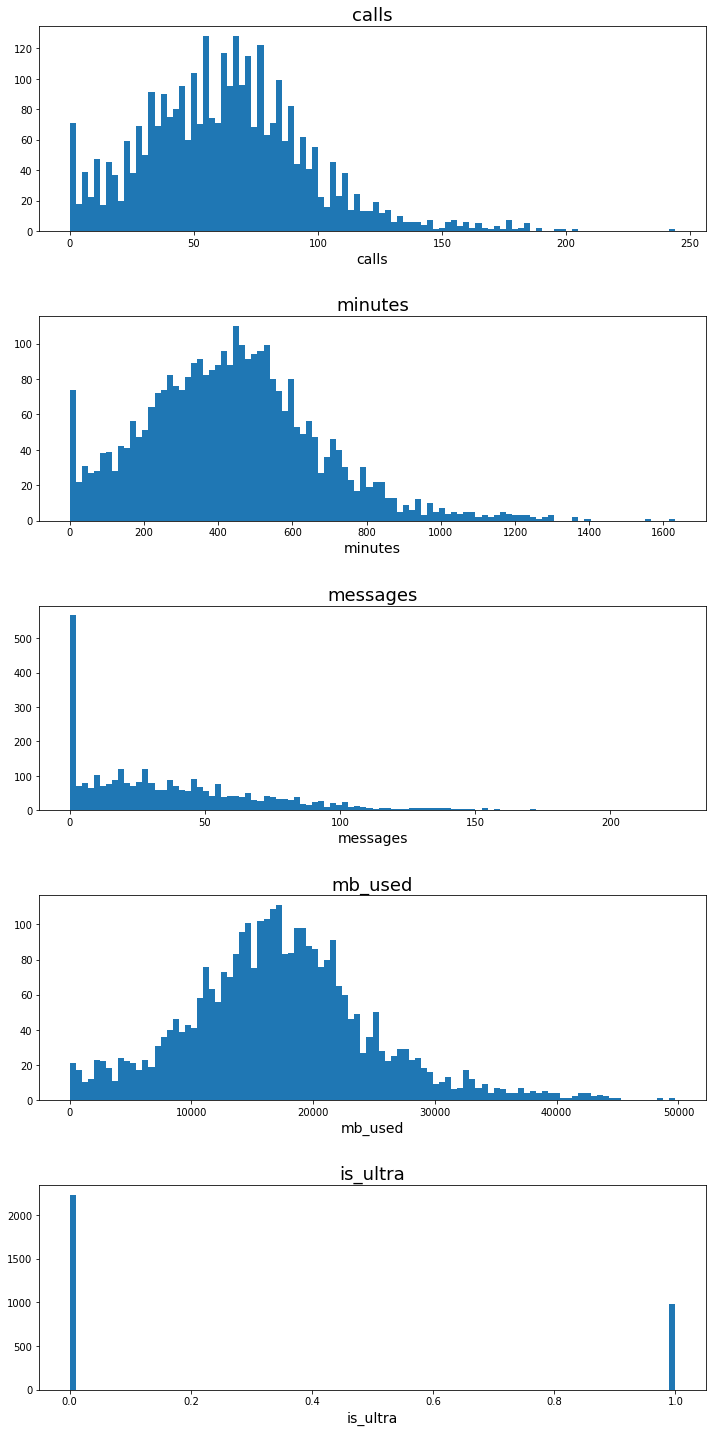

In [5]:
fig, subplots = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))

columns = df.columns
i = -1
for ax in fig.axes:
    i += 1
    ax.hist(df[columns[i]], bins=100)
    
    ax.set_title(columns[i], fontsize=18)
    ax.set_xlabel(columns[i], fontsize=14)
    
plt.tight_layout(h_pad = 3)

plt.show()

Обратим внимание, что в столбцах "calls", "minutes", "messages" большое количество значений находится на 0. Если со столбцом "messages" это, скорее всего, связано с тем, что смс сейчас не распространены, на замену им пришли мессенджеры. Нулевые значения в столбцах "количество звонков" и "суммарная длительность звонков" это пропущенные звонки. Также обратим внимание на одиночные выбросы в "calls" - более 200 звонков, "minutes" - более 1500 минут и "mb_used" - более 45000 Мб. Все это может вилиять на нашу модель. Рассмотрим подробнее эти данные.

In [6]:
df.query('minutes==0 or minutes>=1500')

,calls,minutes,messages,mb_used,is_ultra
54,0.0,0.00,33.0,14010.33,1
247,0.0,0.00,35.0,16444.99,1
264,0.0,0.00,21.0,19559.55,0
351,0.0,0.00,8.0,35525.61,1
390,0.0,0.00,25.0,19088.67,1
484,0.0,0.00,191.0,32448.02,1
551,0.0,0.00,24.0,18701.54,1
647,0.0,0.00,30.0,10236.20,1
769,0.0,0.00,32.0,17206.44,0
884,0.0,0.00,180.0,32045.73,1


In [7]:
df.query('mb_used>=45000')

,calls,minutes,messages,mb_used,is_ultra
957,152.0,1181.82,121.0,49745.73,1
1141,54.0,434.49,0.0,48351.61,1
2657,37.0,258.09,0.0,45180.75,1


Так как нулевые данные могут запутать модель, которая будет пытаться обобщить их, удалим эти данные. Также удалим выбивающиеся значения, как правило, это должно влиять благотворно на обучение и качество модели.

In [8]:
df.drop(df.query('minutes==0 or minutes>=1500 or mb_used>=45000').index, inplace=True, axis=0)

В столбце "is_ultra" данные  распределены неравномерно между тарифами. По тарифу Смарт более чем в 2 раза больше данных чем по тарифу Ультра. При разделении на выборки стоит это учесть.

Рассмотрим взаимосвязь между признаками:

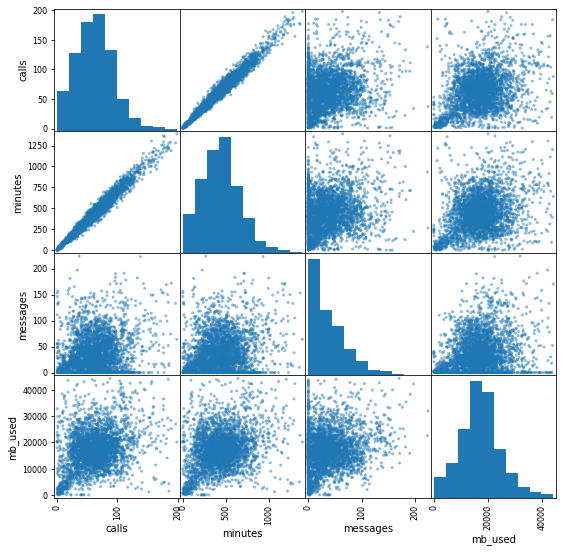

In [9]:
pd.plotting.scatter_matrix(df[['calls', 'minutes', 'messages', 'mb_used']], figsize=(9,9));

In [10]:
df[['calls', 'minutes', 'messages', 'mb_used']].corr()

,calls,minutes,messages,mb_used
calls,1.000000,0.981028,0.196632,0.308912
minutes,0.981028,1.000000,0.191777,0.302266
messages,0.196632,0.191777,1.000000,0.186885
mb_used,0.308912,0.302266,0.186885,1.000000


Между параметрами количеством звонков и продолжительностью минут наблюдается сильная линейная связь - мультиколлинеарность.
Мультиколлинеарность негативно влияет на модели машинного обучения. Так, для линейных моделей она может приводить к неустойчивости коэффициентов. Но так как эти переменные зависимы друг от друга, связь между ними очевидна - чем больше количество звонком тем дольше продолжительность, то удалять их не будем, так как мультиколлинеарность влияет больше на независимые переменные.

## Разбейте данные на выборки

Так как надо разделить выборку на три части, то это будет происходить в два этапа - сначала разделим на обучающую (60%) и проверочную (40%), затем проверочную разделим на тестовую (20%) и валидационную (20%). Также,  как говорилось ранее, чтобы сохнанить соотношение в столбце "is_ultra" используем стратификацию, тогда в обоих выборках будет одинаковый баланс классов. Параметром stratify учитываем однородность выборок.

In [11]:
df_train, df_control = train_test_split(df, test_size=0.4, random_state=12345, stratify=df['is_ultra']) # обучающая и проверочная выборки

In [12]:
df_test, df_valid = train_test_split(df_control, test_size=0.5, random_state=12345, stratify=df_control['is_ultra']) # тестовая и валидационная выборки

In [13]:
df_train.info() # проверка обучающей выборки
df_train['is_ultra'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1901 entries, 3039 to 2263
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     1901 non-null   float64
 1   minutes   1901 non-null   float64
 2   messages  1901 non-null   float64
 3   mb_used   1901 non-null   float64
 4   is_ultra  1901 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 89.1 KB


0    1334
1     567
Name: is_ultra, dtype: int64

In [14]:
df_test.info() # проверка тестовой выборки
df_test['is_ultra'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634 entries, 3013 to 692
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     634 non-null    float64
 1   minutes   634 non-null    float64
 2   messages  634 non-null    float64
 3   mb_used   634 non-null    float64
 4   is_ultra  634 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 29.7 KB


0    444
1    190
Name: is_ultra, dtype: int64

In [15]:
df_valid.info() # проверка валидационной выборки
df_valid['is_ultra'].value_counts()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 634 entries, 112 to 757
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     634 non-null    float64
 1   minutes   634 non-null    float64
 2   messages  634 non-null    float64
 3   mb_used   634 non-null    float64
 4   is_ultra  634 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 29.7 KB


0    445
1    189
Name: is_ultra, dtype: int64

Как видим, выборки распределены равномерно, соотношение тарифом сохраняется во всех трех выборках.

## Исследуйте модели

Обьявим две переменные для каждой выборки: features — признаки (все столбцы, кроме тарифа), target — целевой признак (тариф).

In [16]:
features_train = df_train.drop(['is_ultra'], axis=1) # переменные для обучающей выборки
target_train = df_train['is_ultra']

In [17]:
features_test = df_test.drop(['is_ultra'], axis=1) # переменные для тестовой выборки
target_test = df_test['is_ultra']

In [18]:
features_valid = df_valid.drop(['is_ultra'], axis=1) # переменные для валидационной выборки
target_valid = df_valid['is_ultra']

### Модель "Дерево решений"

In [20]:
best_model_dt = None
best_result_dt = 0
best_depth_dt = 0
list_train=[]
list_valid=[]
list_depth=[]
for depth in range(1,21):
    model_dt = DecisionTreeClassifier(random_state=12345, max_depth=depth)
    model_dt.fit(features_train, target_train)
    result_tree = model_dt.predict(features_valid)
    accuracy_tree = accuracy_score(target_valid, result_tree)
    accurary_train = accuracy_score(target_train, model_dt.predict(features_train)) # Accuracy
    precis_dt = precision_score(target_valid, result_tree, average='weighted') # Precision
    recal_dt = recall_score(target_valid, result_tree, average='weighted') # recall
    f1_dt = f1_score(target_valid, result_tree, average='weighted') # f1
    cm_dt = confusion_matrix(target_valid, result_tree) # confusion_matrix
    list_valid.append(accuracy_tree)
    list_train.append(accurary_train)
    list_depth.append(depth)
    if accuracy_tree > best_result_dt:
        best_model_dt = model_dt
        best_result_dt = accuracy_tree
        best_depth_dt = depth    
print('Accuracy лучшей модели ', round(best_result_dt, 5), '. Глубина:', best_depth_dt)
print('Precision лучшей модели', round(precis_dt, 5))
print('recall лучшей модели', round(recal_dt, 5))
print('f1 лучшей модели', round(f1_dt, 5))
print('confusion_matrix', cm_dt)

Accuracy лучшей модели  0.81073 . Глубина: 4
Precision лучшей модели 0.71839
recall лучшей модели 0.71924
f1 лучшей модели 0.71881
confusion_matrix [[357  88]
 [ 90  99]]


Построим график, где наглядно посмотрим как меняется точность модели на валидационной и обучающей выборок при изменении гиперпараметра.

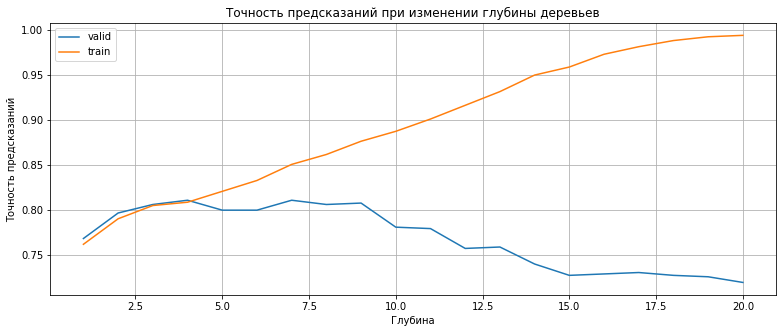

In [230]:
plt.figure(figsize=(13, 5))
plt.plot(list_depth, list_valid, label='valid')
plt.plot(list_depth, list_train, label='train')
plt.grid()
plt.title('Точность предсказаний при изменении глубины деревьев')
plt.xlabel('Глубина')
plt.ylabel('Точность предсказаний');
plt.legend()
plt.show()

По графику видно, что на обучающей выборке чем больше глубина деревьев, тем больше точность предсказаний и она стремится к 100%, что логично. В свою очередь, на валидационной выборке при глубине дереьев более 9 доля правильных объектов падает, что говорит о переобучаемости модели.

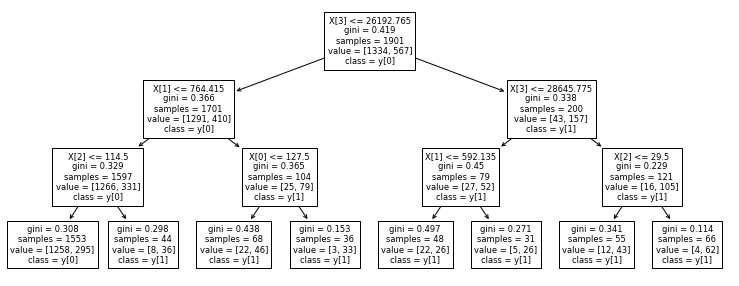

In [231]:
# построение графика дерева решений
plt.figure(figsize=(13, 5))
model_dt_tr = DecisionTreeClassifier(random_state=12345, max_depth=3)
model_dt_tr.fit(features_train, target_train)

tree.plot_tree(model_dt_tr, class_names=True);

### Модель "Случайный лес"

In [29]:
%%time
best_model_rf = None
best_result_rf = 0
best_est_rf = 0
best_depth_rf = 0
for est in range(1, 51, 10):
    for depth in range (1, 11):
        model_rf = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=depth) 
        model_rf.fit(features_train, target_train)
        result = model_rf.score(features_valid, target_valid) # Accuracy
        precis_rf = precision_score(target_valid, model_rf.predict(features_valid), average='weighted') # Precision
        recal_rf = recall_score(target_valid, model_rf.predict(features_valid), average='weighted') # recall
        f1_rf = f1_score(target_valid, model_rf.predict(features_valid), average='weighted') # f1
        cm_rf = confusion_matrix(target_valid, model_rf.predict(features_valid)).ravel # confusion_matrix
        if result > best_result_rf:
            best_model_rf = model_rf
            best_result_rf = result
            best_est_rf = est
            best_depth_rf = depth

print("Accuracy лучшей модели:", round(best_result_rf, 5), 'Количество деревьев:', best_est_rf, 'Глубина:', best_depth_rf)
print('Precision лучшей модели', round(precis_rf, 5))
print('recall лучшей модели', round(recal_rf, 5))
print('f1 лучшей модели', round(f1_rf, 5))
print('confusion_matrix:', cm_rf)

Accuracy лучшей модели: 0.81861 Количество деревьев: 21 Глубина: 7
Precision лучшей модели 0.79818
recall лучшей модели 0.80442
f1 лучшей модели 0.79214
confusion_matrix: [413  32  92  97]
CPU times: user 3.62 s, sys: 35.8 ms, total: 3.66 s
Wall time: 3.66 s


In [233]:
%%time
# модель через GridSearchCV
mod = RandomForestClassifier()
parametrs = { 'n_estimators': range (1, 51, 10),
              'max_depth': range (1, 11) }
grid = GridSearchCV(mod, parametrs, cv=5)
grid.fit(features_train, target_train)
rf_3 = grid.best_estimator_
print(grid.best_score_)
print(grid.best_estimator_)

0.8111534742367731
RandomForestClassifier(max_depth=9, n_estimators=41)
CPU times: user 13.2 s, sys: 91.7 ms, total: 13.3 s
Wall time: 13.4 s


### Логистическая регрессия

In [21]:
model_lr = LogisticRegression(random_state=12345, solver='lbfgs', max_iter=1000)
model_lr.fit(features_train, target_train)
predictions_valid = model_lr.predict(features_valid)
accuracy_lr = model_lr.score(features_valid, target_valid)
precis_lr = precision_score(target_valid, predictions_valid, average='weighted') # Precision
recal_lr = recall_score(target_valid, predictions_valid, average='weighted') # recall
f1_lr = f1_score(target_valid, predictions_valid, average='weighted') # f1
cm_lr = confusion_matrix(target_valid, predictions_valid)
print("Accuracy :", round(accuracy_lr, 5))
print('Precision лучшей модели', round(precis_lr, 5))
print('recall лучшей модели', round(recal_lr, 5))
print('f1 лучшей модели', round(f1_lr, 5))
print('confusion_matrix:', cm_lr)

Accuracy : 0.76498
Precision лучшей модели 0.7754
recall лучшей модели 0.76498
f1 лучшей модели 0.7214
confusion_matrix: [[433  12]
 [137  52]]


Таким образом, лучшей моделью является модель "Случайного леса" с долей правильных ответов практически 82% при глубине 7 и количестве деревьев 21.
На втором месте модель "Дерево решений" с долей правильных ответов 81% и глубине 4.

## Проверьте модель на тестовой выборке

Проверяем лучшую модель "Случайный лес" на тестовой выборке

In [235]:
model_test = RandomForestClassifier(random_state=12345, n_estimators=21, max_depth=7) 
model_test.fit(features_train, target_train) 
result = model_test.score(features_test, target_test) 
       

print("Accuracy на тестовой выборке:", round(result,5))

Accuracy на тестовой выборке: 0.80915


Модель на тестовой выборке показывается меньший процент правильных ответов, но все равно более 80%.

Соединим валидационную и обучающую выборку для проверки и проверим модель на тестовой выборки еще раз

In [240]:
features_total = pd.concat((features_train, features_valid), axis=0)
target_total = pd.concat((target_train, target_valid), axis=0)

In [241]:
model_test = RandomForestClassifier(random_state=12345, n_estimators=21, max_depth=7) 
model_test.fit(features_total, target_total) 
result = model_test.score(features_test, target_test) 
       

print("Accuracy на тестовой выборке:", round(result,5))

Accuracy на тестовой выборке: 0.80442


## (бонус) Проверьте модели на адекватность

Чтобы убедиться, что наша модель выполняет свою работу и имеет предсказательную силу, проверим адекватность модели используя специальную модель - sklearn.dummy.DummyClassifier. Так как данные по тарифам распределены неравномерно, используем strategy="most_frequent"

In [89]:
dummy_clf = DummyClassifier(strategy="most_frequent", random_state=12345)
dummy_clf.fit(features_train, target_train)
dummy_clf.predict(features_valid)
print('Accurary случайной модели:', round(dummy_clf.score(features_test, target_test), 5))

Accurary случайной модели: 0.70032


Таким образом, наша модель ведет себя лучше, это значит, что она имеет предсказательную силу. Можно сделать вывод, что модель подобрана правильно. 

## Общий вывод

В данном проекте была построена модель для задачи классификации, которая выбирает подходящий тариф.
Для этого, при изучении исходных данных было обнаружено, что в модели присутствуют нулевые значения в столбцах "calls" и "minutes", а также одиночные выбросы в столбцах "calls", "minutes" и "mb_used". Так как нулевые значения могли запутать модель, а удаление выбросов благотворно влияет на ее предсказательную силу, удалили эти данные.  Между "calls" и "minutes" была обнаружена мультиколлинеарность - сильная взаимосвязь между параметрами, но так как эти параметры зависимы друг от друга, оставили их без изменений. 
Данные были разбиты на три выборки - обучающая (60%), тестовая(20%) и валидационная(20%). Так как данные в столбце "is_ultra" у нас неоднородны, при делении на выборки была использована стратификация, тогда во всех выборках сохранено соотношение тарифов.

Были объявлены две переменные для каждой выборки: features — признаки (все столбцы, кроме тарифа), target — целевой признак (тариф).

Далее были построены и исследованы три модели - модель "Дерево решений", модель "Случайный лес" и логистическая регрессия. Лучшей моделью является модель "Случайного леса" с долей правильных ответов практически 82% при глубине 7 и количестве деревьев 21. Данная модель была проверена на тестовых данных, которая показала Accuracy практически 81%, что говорит о том, что модель имеет предсказательную базу, а не просто заучила ответы.
Модель "Случайный лес" была проверена на адекватность через sklearn.dummy.DummyClassifier. Наша модель показала больше правильных ответом, что говорит о том, что она подобрана правильно и имеет предсказательную силу.
Таким образом, можно использовать данную модель для предложения клиентам заказчика новых тарифов "Смарт" или "Ультра".


